# Assignment 5 - Applied Machine Learning
---
## Arghadeep Ghosh

This notebook 'Image Classifier.ipynb' contains the code for finetuning a BERT network for sentiment classification

In [2]:
# Importing modules

import random, time, glob 
import pandas as pd
import torch


import numpy as np
import torch.optim as optim
import torch.nn as nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader, Dataset, RandomSampler, SequentialSampler

from transformers import BertForSequenceClassification, BertTokenizerFast
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

## Building the DataLoader
---

The data is read from the csv as a list of tuple containing the sentence and its label. The data is tokenized using a pre-trained BERT tokenizer and wrapped in a PyTorch DataLoader class

In [6]:
def load_data():
    train_data = pd.read_csv(open("Data/train.csv", errors="replace"))
    test_data = pd.read_csv(open("Data/test.csv", errors="replace"))
    
    train_data = train_data.dropna()
    test_data = test_data.dropna()
    
    train_data = train_data.replace(['negative', 'neutral', 'positive'], [0, 1, 2])
    test_data = test_data.replace(['negative', 'neutral', 'positive'], [0, 1, 2])
    
    train_text, train_label = train_data['text'].tolist(), train_data['sentiment'].tolist()
    test_text, test_label = test_data['text'].tolist(), test_data['sentiment'].tolist()
    
    return train_text, train_label, test_text, test_label

train_text, train_label, test_text, test_label = load_data()
len(train_text), len(train_label), len(test_text), len(test_label)

(27480, 27480, 3534, 3534)

In [7]:
# tokenize and encode sequences in the training set
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased', do_lower_case=True)

train_tokens = tokenizer.batch_encode_plus(train_text, max_length = 25, pad_to_max_length=True, return_token_type_ids=False)
test_tokens = tokenizer.batch_encode_plus(test_text, max_length = 25, pad_to_max_length=True, return_token_type_ids=False)

len(train_tokens), len(test_tokens)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\Argodep\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


(2, 2)

In [8]:
train_seq = torch.tensor(train_tokens['input_ids'])
train_mask = torch.tensor(train_tokens['attention_mask'])
train_y = torch.tensor(train_label)

test_seq = torch.tensor(test_tokens['input_ids'])
test_mask = torch.tensor(test_tokens['attention_mask'])
test_y = torch.tensor(test_label)

train_seq.shape, train_mask.shape, train_y.shape, test_seq.shape, test_mask.shape, test_y.shape

(torch.Size([27480, 25]),
 torch.Size([27480, 25]),
 torch.Size([27480]),
 torch.Size([3534, 25]),
 torch.Size([3534, 25]),
 torch.Size([3534]))

## Loading the Pre-trained Model
---

The BERT Model is loaded and its final layer is modified to produce a three-way classification

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' 

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 3, # The number of output labels--3 for pos/neu/neg classification.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)
# for param in model.parameters():
#     param.requires_grad = False

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [6]:
# class BERT_Finetuned(nn.Module):
#     def __init__(self, bert):      
#         super(BERT_Finetuned, self).__init__()

#         self.bert = bert 

#         # dropout layer
#         self.dropout = nn.Dropout(0.1)

#         self.relu =  nn.ReLU()
#         self.fc1 = nn.Linear(768,768)
#         self.fc2 = nn.Linear(768,3)

#     #define the forward pass
#     def forward(self, sent_id, mask):
#         # pass the inputs to the model  
#         _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict = False)
#         x = self.fc1(cls_hs)
#         x = self.relu(x)
#         x = self.dropout(x)
#         x = self.fc2(x)

#         return x
    
# model = BERT_Finetuned(bert)

model.to(device)
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

## Training the Model

---

The model hyperparameters are set and the model is finetuned for the classification task

In [9]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr = 1e-4)
batch_size = 32

train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

test_data = TensorDataset(test_seq, test_mask, test_y)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size=batch_size)

len(train_data), len(test_data)

(27480, 3534)

### Loss and Accuracy before Training

----------------------------------------------------------------------------------------------------
Batch 0/111
----------------------------------------------------------------------------------------------------
Batch 20/111
----------------------------------------------------------------------------------------------------
Batch 40/111
----------------------------------------------------------------------------------------------------
Batch 60/111
----------------------------------------------------------------------------------------------------
Batch 80/111
----------------------------------------------------------------------------------------------------
Batch 100/111
----------------------------------------------------------------------------------------------------
TESTING LOSS: 0.0342, TESTING ACCURACY: 0.4046


(0.03419620058397553, 0.4046406338426712)

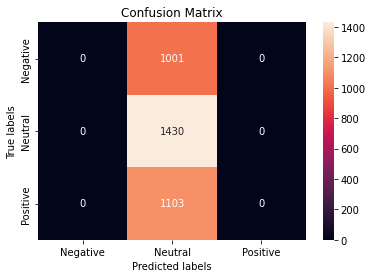

In [8]:
def evaluate():
    model.eval()

    total_loss, total_acc = 0, 0
    
    Y = []
    Y_pred = []

    for step, batch in enumerate(test_dataloader):
        if step % 20 == 0:
            print("-"*100)
            print(f"Batch {step}/{len(test_dataloader)}")
        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

        # deactivate autograd
        with torch.no_grad():
            preds = model(sent_id, mask).logits
            loss = F.cross_entropy(preds,labels)
            total_loss = total_loss + loss.item()
            
            Y += [labels.cpu().detach().numpy()]
            Y_pred += [preds.cpu().detach().numpy()]
            
            correct = 0
            for p in range(len(labels)):
                pred = torch.argmax(preds[p])
                if pred == int(labels[p]):
                    correct += 1
            
            total_acc += correct


        avg_loss = total_loss / len(test_data)
        avg_acc = total_acc / len(test_data)
        
    print("-"*100)
    print(f"TESTING LOSS: {avg_loss:.4f}, TESTING ACCURACY: {avg_acc:.4f}")
    
    Y = np.concatenate(Y, axis = 0)
    Y_pred = np.argmax(np.concatenate(Y_pred, axis = 0), axis = 1)

    cm = confusion_matrix(Y, Y_pred)

    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['Negative', 'Neutral', 'Positive']); ax.yaxis.set_ticklabels(['Negative', 'Neutral', 'Positive']);
    return avg_loss, avg_acc
    
evaluate()

EPOCH: 0
----------------------------------------------------------------------------------------------------
Batch 0/859
----------------------------------------------------------------------------------------------------
Batch 100/859
----------------------------------------------------------------------------------------------------
Batch 200/859
----------------------------------------------------------------------------------------------------
Batch 300/859
----------------------------------------------------------------------------------------------------
Batch 400/859
----------------------------------------------------------------------------------------------------
Batch 500/859
----------------------------------------------------------------------------------------------------
Batch 600/859
----------------------------------------------------------------------------------------------------
Batch 700/859
-------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
Batch 100/111
----------------------------------------------------------------------------------------------------
TESTING LOSS: 0.0232, TESTING ACCURACY: 0.7385
EPOCH: 4
----------------------------------------------------------------------------------------------------
Batch 0/859
----------------------------------------------------------------------------------------------------
Batch 100/859
----------------------------------------------------------------------------------------------------
Batch 200/859
----------------------------------------------------------------------------------------------------
Batch 300/859
----------------------------------------------------------------------------------------------------
Batch 400/859
----------------------------------------------------------------------------------------------------
Batch 500/859
----------------------------------------

----------------------------------------------------------------------------------------------------
Batch 60/111
----------------------------------------------------------------------------------------------------
Batch 80/111
----------------------------------------------------------------------------------------------------
Batch 100/111
----------------------------------------------------------------------------------------------------
TESTING LOSS: 0.0358, TESTING ACCURACY: 0.7391
EPOCH: 8
----------------------------------------------------------------------------------------------------
Batch 0/859
----------------------------------------------------------------------------------------------------
Batch 100/859
----------------------------------------------------------------------------------------------------
Batch 200/859
----------------------------------------------------------------------------------------------------
Batch 300/859
------------------------------------------

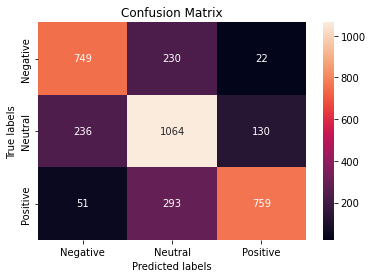

In [9]:
# function to train the model
epochs = 10

best_acc = 0
for i in range(epochs):
    model.train()
    total_loss, total_acc = 0, 0
    
    print("="*100)
    print(f"EPOCH: {i}")
    # iterate over batches
    for step, batch in enumerate(train_dataloader):
        if step % 100 == 0:
            print("-"*100)
            print(f"Batch {step}/{len(train_dataloader)}")

        batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch

        # clear previously calculated gradients 
        model.zero_grad()        
        preds = model(sent_id, mask).logits
        loss = F.cross_entropy(preds, labels)
        
        loss.backward()
        optimizer.step()
        
        correct = 0
        for p in range(len(labels)):
            pred = torch.argmax(preds[p])
            if pred == int(labels[p]):
                correct += 1
                
        total_loss += loss
        total_acc += correct

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        

    avg_loss = total_loss / len(train_data)
    avg_acc = total_acc / len(train_data)
    print("-"*100)
    print(f"TRAINING LOSS: {avg_loss:.4f}, TRAINING ACCURACY: {avg_acc:.4f}")
    
    test_loss, test_acc = evaluate()
    
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model, "model")

### Loss and Accuracy after Training

----------------------------------------------------------------------------------------------------
Batch 0/111
----------------------------------------------------------------------------------------------------
Batch 20/111
----------------------------------------------------------------------------------------------------
Batch 40/111
----------------------------------------------------------------------------------------------------
Batch 60/111
----------------------------------------------------------------------------------------------------
Batch 80/111
----------------------------------------------------------------------------------------------------
Batch 100/111
----------------------------------------------------------------------------------------------------
TESTING LOSS: 0.0182, TESTING ACCURACY: 0.7583


(0.01820497098418367, 0.758347481607244)

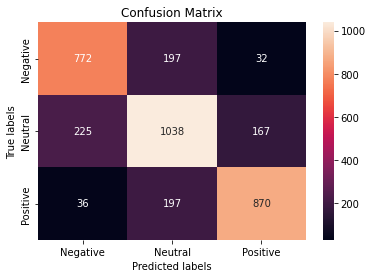

In [12]:
model = torch.load("model")

evaluate()